In [17]:
import os
import sklearn
import pandas as pd
import keras_tuner as kt
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error,root_mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('data.csv')

X_test = pd.read_csv('X_test.csv')
X_train = pd.read_csv('X_train.csv')
y_test = pd.read_csv('y_test.csv')
y_train = pd.read_csv('y_train.csv')

In [3]:
print("Data shape",data.shape,"\n")
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

Data shape (1251, 14) 

X_train shape (1000, 5)
y_train shape (1000, 1)
X_test shape (251, 5)
y_test shape (251, 1)


In [4]:
# Convert X_train and X_test to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values

X_train_bilstm = X_train_np.reshape((X_train.shape[0], 1, X_train.shape[1])) 
X_test_bilstm = X_test_np.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [27]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(X_train_bilstm.shape[1], X_train_bilstm.shape[2]))))
bilstm_model.add(Dense(10))
bilstm_model.add(Dense(units=1))

bilstm_model.compile(optimizer='adam', loss='mse',metrics=['mae'])

c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
early_stopping = EarlyStopping(patience=3)

In [29]:
history = bilstm_model.fit(X_train_bilstm, y_train, epochs=30, batch_size=32, validation_data=(X_test_bilstm, y_test),callbacks=[early_stopping])

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0918 - mae: 0.2429 - val_loss: 0.0413 - val_mae: 0.1722
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349 - mae: 0.1570 - val_loss: 0.0315 - val_mae: 0.1496
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0331 - mae: 0.1531 - val_loss: 0.0288 - val_mae: 0.1410
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0306 - mae: 0.1458 - val_loss: 0.0304 - val_mae: 0.1434
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0299 - mae: 0.1437 - val_loss: 0.0250 - val_mae: 0.1331
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0287 - mae: 0.1429 - val_loss: 0.0259 - val_mae: 0.1339
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0321 - mae: 0.1487 - val_loss: 0.0265 - val_mae: 0.1348
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0333 - mae: 0.1473 - val_loss: 0.0254 - val_mae: 0.1320


In [30]:
y_pred_bilstm = bilstm_model.predict(X_test_bilstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [32]:
y_pred_bilstm_flat = y_pred_bilstm.flatten()
y_test_flat = y_test.values.flatten()

mae_bilstm = mean_absolute_error(y_test_flat, y_pred_bilstm_flat)
mse_bilstm = mean_squared_error(y_test_flat, y_pred_bilstm_flat)
rmse_bilstm = root_mean_squared_error(y_test_flat, y_pred_bilstm_flat)

print(f'MAE: {mae_bilstm:.4f}')
print(f'MSE: {mse_bilstm:.4f}')
print(f'RMSE: {rmse_bilstm:.4f}')

MAE: 0.1320
MSE: 0.0254
RMSE: 0.1594


In [33]:
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

y_pred_bilstm_flat = y_pred_bilstm.flatten()
y_test_flat = y_test.flatten()

results_bilstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_bilstm_flat.round(4)})
print(results_bilstm)

     Actual SOH  Predicted SOH
0        0.1231         0.2668
1        0.3744         0.2708
2        0.1782         0.2688
3        0.4869         0.2668
4        0.3438         0.6870
..          ...            ...
246      0.7323         0.7153
247      0.2741         0.2668
248      0.2306         0.2673
249      0.1856         0.2865
250      0.2840         0.2668

[251 rows x 2 columns]


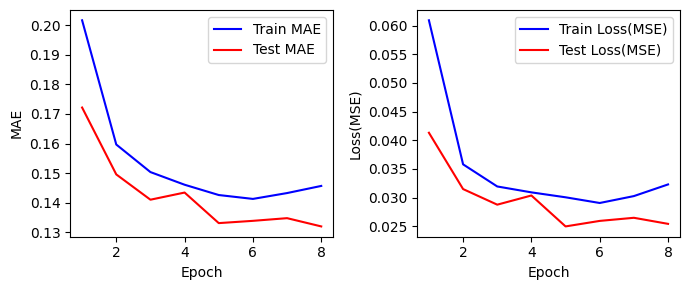

In [34]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

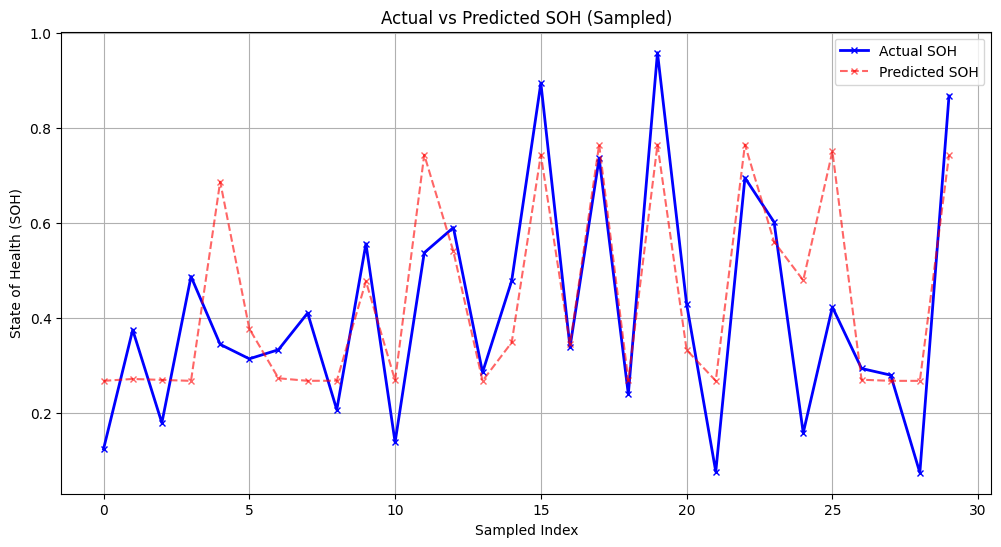

In [35]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_bilstm[:sample_size]

y_pred_sample_flat = y_pred_sample.flatten()

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

**# Hyperband Tuning, 1 Hidden Layer**

In [21]:
def build_model(hp):
    units1 = hp.Int('units1', min_value=50, max_value=150, step=10)  # BILSTM units
    units2 = hp.Int('units2', min_value=10, max_value=100, step=10)  # Dense units
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh']) # Activation function
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    dropout = hp.Choice('dropout', values=[0.0, 0.2, 0.3])  # Dropout rate
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])  # Learning rate

    model = Sequential()
    model.add(Bidirectional(LSTM(units=units1, input_shape=(X_train_bilstm.shape[1], X_train_bilstm.shape[2]))))
    model.add(Dense(units=units2, activation=activation_1))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
   
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [46]:
tuner = kt.Hyperband(build_model,
                    objective='val_loss', 
                    max_epochs=50,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_1hidden_bilstm')

Reloading Tuner from my_dir\hyperband_1hidden_bilstm\tuner0.json


In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train_bilstm, y_train, validation_data=(X_test_bilstm, y_test),
                         callbacks=[early_stopping])

In [48]:
# Get the best hyperparameter
best_bilstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best BiLSTM hyperparameters:', best_bilstm_hps.values)

Best BiLSTM hyperparameters: {'units1': 90, 'units2': 60, 'activation_1': 'tanh', 'batch_size': 16, 'dropout': 0.0, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0060'}


In [49]:
best_bilstm_model = tuner.hypermodel.build(best_bilstm_hps)

history = best_bilstm_model.fit(X_train_bilstm, y_train, epochs=100, batch_size=best_bilstm_hps.get('batch_size'),
                                validation_data=(X_test_bilstm, y_test), callbacks=[early_stopping])

Epoch 1/100


c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2063 - mae: 0.3492 - val_loss: 0.0529 - val_mae: 0.1837
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 - mae: 0.1718 - val_loss: 0.0390 - val_mae: 0.1650
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349 - mae: 0.1545 - val_loss: 0.0244 - val_mae: 0.1291
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0305 - mae: 0.1408 - val_loss: 0.0257 - val_mae: 0.1336
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 - mae: 0.1378 - val_loss: 0.0298 - val_mae: 0.1374
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0282 - mae: 0.1368 - val_loss: 0.0318 - val_mae: 0.1409


In [50]:
y_pred_bilstm = best_bilstm_model.predict(X_test_bilstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [51]:
y_pred_bilstm_flat = y_pred_bilstm.flatten()
y_test_flat = y_test.values.flatten()

mae_lstm = mean_absolute_error(y_test_flat, y_pred_bilstm_flat)
mse_lstm = mean_squared_error(y_test_flat, y_pred_bilstm_flat)
rmse_lstm = root_mean_squared_error(y_test_flat, y_pred_bilstm_flat)

print(f'MAE: {mae_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')

MAE: 0.1291
MSE: 0.0244
RMSE: 0.1561


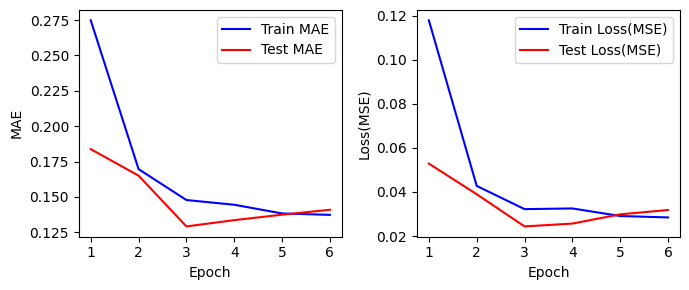

In [53]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [56]:
# Ensure y_test is a NumPy array (if it's a DataFrame or Series)
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

# Ensure y_pred_ann is 1-dimensional
y_pred_bilstm_flat = y_pred_bilstm.flatten()

# Ensure y_test is also 1-dimensional if it isn't already
y_test_flat = y_test.flatten()

# Create a DataFrame to hold actual and predicted values
results_bilstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_bilstm_flat.round(4)})

# Print the actual and predicted SOH values
print(results_bilstm)

     Actual SOH  Predicted SOH
0        0.1231         0.1988
1        0.3744         0.2136
2        0.1782         0.2069
3        0.4869         0.1986
4        0.3438         0.6464
..          ...            ...
246      0.7323         0.6680
247      0.2741         0.1986
248      0.2306         0.2018
249      0.1856         0.2562
250      0.2840         0.1987

[251 rows x 2 columns]


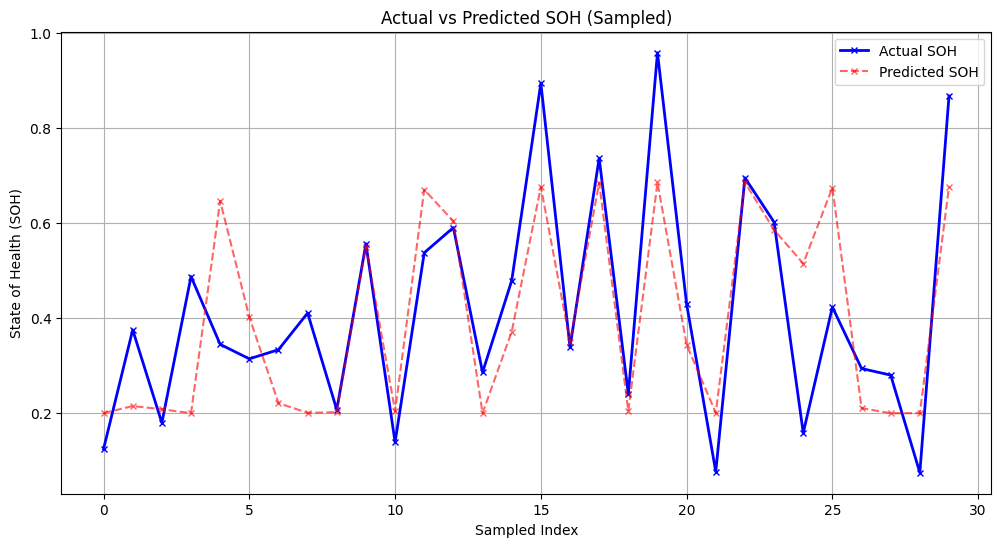

In [57]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_bilstm[:sample_size]

y_pred_sample_flat = y_pred_sample.flatten()

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

**# Hyperband Tuning, 2 Hidden Layers**

In [52]:
def build_model(hp):
    units1 = hp.Int('units1', min_value=50, max_value=150, step=10)  # BILSTM units
    units2 = hp.Int('units2', min_value=10, max_value=100, step=10)  # Hidden layer 1
    units3 = hp.Int('units3', min_value=10, max_value=100, step=10)  # Hidden layer 2
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh']) # Activation function
    activation_2 = hp.Choice('activation_2', values=['relu', 'tanh']) # Activation function
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    dropout1 = hp.Choice('dropout1', values=[0.0, 0.2, 0.3])  # Dropout rate 1
    dropout2 = hp.Choice('dropout2', values=[0.0, 0.2, 0.3])  # Dropout rate 2
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])  # Learning rate

    model = Sequential()
    model.add(Bidirectional(LSTM(units=units1, input_shape=(X_train_bilstm.shape[1], X_train_bilstm.shape[2]))))
    model.add(Dense(units=units2, activation=activation_1))
    model.add(Dropout(dropout1))
    model.add(Dense(units=units3, activation=activation_2))
    model.add(Dropout(dropout2))
    model.add(Dense(1))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
   
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [53]:
tuner = kt.Hyperband(build_model,
                    objective='val_loss', # MSE
                    max_epochs=50,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_2hidden_bilstm')

c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train_bilstm, y_train, validation_data=(X_test_bilstm, y_test),
                         callbacks=[early_stopping])

Trial 88 Complete [00h 00m 23s]
val_loss: 0.07510638236999512

Best val_loss So Far: 0.023137548938393593
Total elapsed time: 00h 16m 30s


In [55]:
# Get the best hyperparameter
best_bilstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best BiLSTM hyperparameters:', best_bilstm_hps.values)

Best BiLSTM hyperparameters: {'units1': 140, 'units2': 100, 'units3': 70, 'activation_1': 'tanh', 'activation_2': 'relu', 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.0, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0060'}


In [56]:
best_bilstm_model = tuner.hypermodel.build(best_bilstm_hps)

history = best_bilstm_model.fit(X_train_bilstm, y_train, epochs=100, batch_size=best_bilstm_hps.get('batch_size'),validation_data=(X_test_bilstm, y_test), callbacks=[early_stopping])

Epoch 1/100


c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1594 - mae: 0.3217 - val_loss: 0.0268 - val_mae: 0.1374
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0414 - mae: 0.1662 - val_loss: 0.0276 - val_mae: 0.1326
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0350 - mae: 0.1484 - val_loss: 0.0351 - val_mae: 0.1471
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0371 - mae: 0.1560 - val_loss: 0.0267 - val_mae: 0.1308
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0369 - mae: 0.1565 - val_loss: 0.0226 - val_mae: 0.1261
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0319 - mae: 0.1469 - val_loss: 0.0319 - val_mae: 0.1417
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0296 - mae: 0.1416 - val_loss: 0.0225 - val_mae: 0.1234
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0294 - mae: 0.1399 - val_loss: 0.0231 - val_mae: 0.1263
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0301 - mae: 0

In [57]:
y_pred_bilstm = best_bilstm_model.predict(X_test_bilstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [58]:
y_pred_bilstm_flat = y_pred_bilstm.flatten()
y_test_flat = y_test.values.flatten()

mae_lstm = mean_absolute_error(y_test_flat, y_pred_bilstm_flat)
mse_lstm = mean_squared_error(y_test_flat, y_pred_bilstm_flat)
rmse_lstm = root_mean_squared_error(y_test_flat, y_pred_bilstm_flat)

print(f'MAE: {mae_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')

MAE: 0.1234
MSE: 0.0225
RMSE: 0.1500


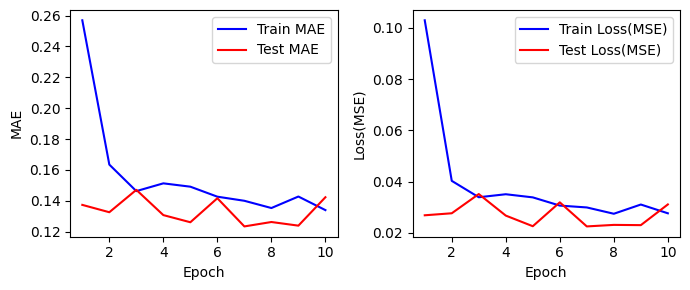

In [59]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [60]:
# Ensure y_test is a NumPy array (if it's a DataFrame or Series)
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

# Ensure y_pred_ann is 1-dimensional
y_pred_bilstm_flat = y_pred_bilstm.flatten()

# Ensure y_test is also 1-dimensional if it isn't already
y_test_flat = y_test.flatten()

# Create a DataFrame to hold actual and predicted values
results_bilstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_bilstm_flat.round(4)})

# Print the actual and predicted SOH values
print(results_bilstm)

     Actual SOH  Predicted SOH
0        0.1231         0.1752
1        0.3744         0.2466
2        0.1782         0.2259
3        0.4869         0.1700
4        0.3438         0.6101
..          ...            ...
246      0.7323         0.6242
247      0.2741         0.1684
248      0.2306         0.2097
249      0.1856         0.3282
250      0.2840         0.1727

[251 rows x 2 columns]


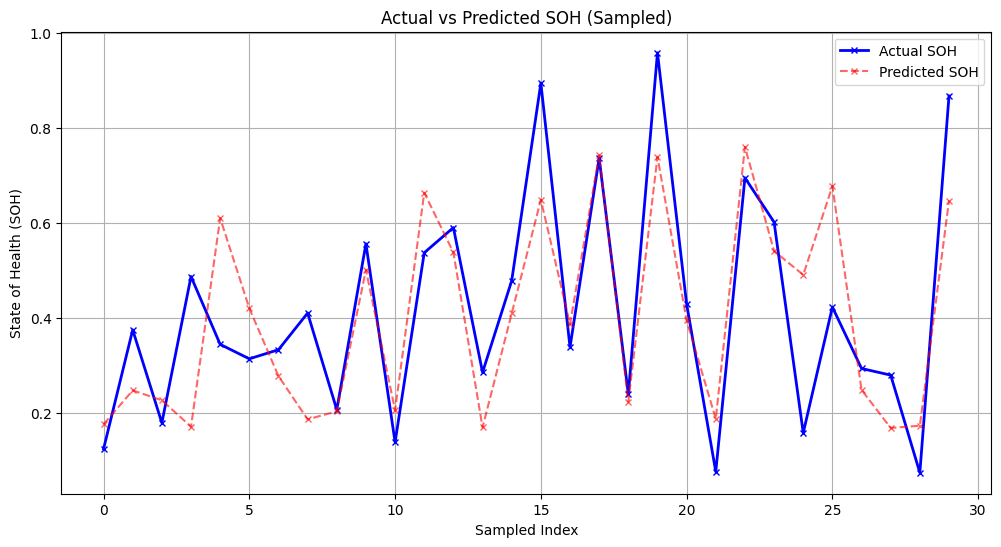

In [61]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_bilstm[:sample_size]

y_pred_sample_flat = y_pred_sample.flatten()

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()

**# Hyperband Tuning, 3 Hidden Layers**

In [8]:
def build_model(hp):
    units1 = hp.Int('units1', min_value=50, max_value=150, step=10)  # BILSTM units
    units2 = hp.Int('units2', min_value=10, max_value=100, step=10)  # Hidden layer 1
    units3 = hp.Int('units3', min_value=10, max_value=100, step=10)  # Hidden layer 2
    units4 = hp.Int('units4', min_value=10, max_value=100, step=10)  # Hidden layer 3
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh']) # Activation function
    activation_2 = hp.Choice('activation_2', values=['relu', 'tanh']) # Activation function
    activation_3 = hp.Choice('activation_3', values=['relu', 'tanh']) # Activation function
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    dropout1 = hp.Choice('dropout1', values=[0.0, 0.2, 0.3])  # Dropout rate 1
    dropout2 = hp.Choice('dropout2', values=[0.0, 0.2, 0.3])  # Dropout rate 2
    dropout3 = hp.Choice('dropout3', values=[0.0, 0.2, 0.3])  # Dropout rate 3
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])  # Learning rate

    model = Sequential()
    model.add(Bidirectional(LSTM(units=units1, input_shape=(X_train_bilstm.shape[1], X_train_bilstm.shape[2]))))
    model.add(Dense(units=units2, activation=activation_1))
    model.add(Dropout(dropout1))
    model.add(Dense(units=units3, activation=activation_2))
    model.add(Dropout(dropout2))
    model.add(Dense(units=units4, activation=activation_3))
    model.add(Dropout(dropout3))
    model.add(Dense(1))

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
   
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [9]:
tuner = kt.Hyperband(build_model,
                    objective='val_loss', # MSE
                    max_epochs=50,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_3hidden_bilstm')

c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train_bilstm, y_train, validation_data=(X_test_bilstm, y_test),
                         callbacks=[early_stopping])

Trial 90 Complete [00h 00m 09s]
val_loss: 0.02344263717532158

Best val_loss So Far: 0.022784410044550896
Total elapsed time: 00h 10m 01s


In [11]:
# Get the best hyperparameter
best_bilstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best BiLSTM hyperparameters:', best_bilstm_hps.values)

Best BiLSTM hyperparameters: {'units1': 100, 'units2': 10, 'units3': 30, 'units4': 90, 'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'relu', 'batch_size': 32, 'dropout1': 0.0, 'dropout2': 0.0, 'dropout3': 0.0, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0074'}


In [12]:
best_bilstm_model = tuner.hypermodel.build(best_bilstm_hps)

history = best_bilstm_model.fit(X_train_bilstm, y_train, epochs=100, batch_size=best_bilstm_hps.get('batch_size'),validation_data=(X_test_bilstm, y_test), callbacks=[early_stopping])

Epoch 1/100


c:\Users\hp\Documents\FYP\dashboard\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1110 - mae: 0.2700 - val_loss: 0.0342 - val_mae: 0.1537
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - mae: 0.1494 - val_loss: 0.0253 - val_mae: 0.1298
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296 - mae: 0.1397 - val_loss: 0.0275 - val_mae: 0.1360
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307 - mae: 0.1424 - val_loss: 0.0262 - val_mae: 0.1359
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0272 - mae: 0.1364 - val_loss: 0.0325 - val_mae: 0.1434


In [13]:
y_pred_bilstm = best_bilstm_model.predict(X_test_bilstm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [15]:
y_pred_bilstm_flat = y_pred_bilstm.flatten()
y_test_flat = y_test.values.flatten()

mae_lstm = mean_absolute_error(y_test_flat, y_pred_bilstm_flat)
mse_lstm = mean_squared_error(y_test_flat, y_pred_bilstm_flat)
rmse_lstm = root_mean_squared_error(y_test_flat, y_pred_bilstm_flat)

print(f'MAE: {mae_lstm:.4f}')
print(f'MSE: {mse_lstm:.4f}')
print(f'RMSE: {rmse_lstm:.4f}')

MAE: 0.1298
MSE: 0.0253
RMSE: 0.1589


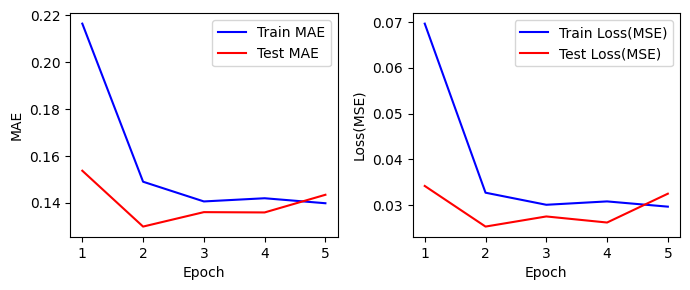

In [18]:
acc2 = history.history['mae']
val_acc = history.history['val_mae']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train MAE')
axes[0].plot(epochs, val_acc,'r',label='Test MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

axes[1].plot(epochs, loss2,'b',label='Train Loss(MSE)')
axes[1].plot(epochs, val_loss,'r',label='Test Loss(MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss(MSE)')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [19]:
# Ensure y_test is a NumPy array (if it's a DataFrame or Series)
if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
    y_test = y_test.values

# Ensure y_pred_ann is 1-dimensional
y_pred_bilstm_flat = y_pred_bilstm.flatten()

# Ensure y_test is also 1-dimensional if it isn't already
y_test_flat = y_test.flatten()

# Create a DataFrame to hold actual and predicted values
results_bilstm = pd.DataFrame({'Actual SOH': y_test_flat, 'Predicted SOH': y_pred_bilstm_flat.round(4)})

# Print the actual and predicted SOH values
print(results_bilstm)

     Actual SOH  Predicted SOH
0        0.1231         0.1930
1        0.3744         0.2559
2        0.1782         0.2343
3        0.4869         0.1900
4        0.3438         0.6583
..          ...            ...
246      0.7323         0.6615
247      0.2741         0.1895
248      0.2306         0.2259
249      0.1856         0.2904
250      0.2840         0.1912

[251 rows x 2 columns]


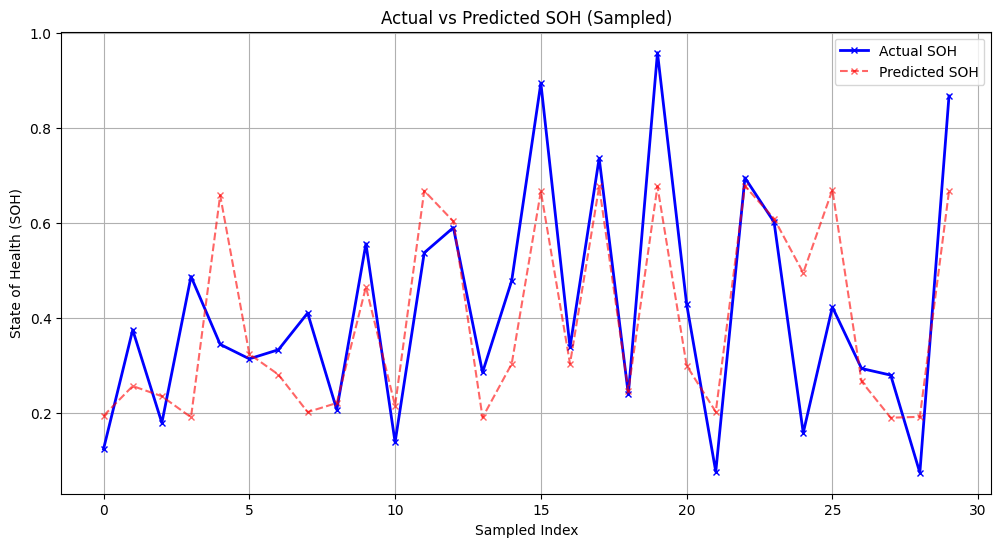

In [20]:
# Sample data for clearer visualization if the dataset is large
sample_size = 30  # adjust sample size as needed
y_test_sample = y_test[:sample_size]
y_pred_sample = y_pred_bilstm[:sample_size]

y_pred_sample_flat = y_pred_sample.flatten()

# Plot actual and predicted SOH with transparency and markers
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample, label='Actual SOH', color='blue',marker='x', markersize=5, linewidth=2)
plt.plot(y_pred_sample_flat, label='Predicted SOH', color='red', linestyle='--', marker='x', markersize=5, alpha=0.6)
plt.title('Actual vs Predicted SOH (Sampled)')
plt.xlabel('Sampled Index')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.grid(True)
plt.show()